# DYNASTY - SHRED: verification on parametric transients

This notebook implements the SHRED architecture to the RELAP5 of the DYNASTY facility, considering the case in which only model data are available.

This serves as verification/test of the SHRED architecture on parametric data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

Let us import the data

In [2]:
path_snaps = '../../NuSHRED_Datasets/D3/parametric_dataset.npz'

data = np.load(path_snaps, allow_pickle=True)

# Load the data
snap_data_dict = data['snaps'].item()
param_mu = data['param_mu']
simulation_time = data['simulation_time']
target_idx = data['target_idx']

var_names = list(snap_data_dict.keys())

Nt = len(simulation_time)
ntrajectories = len(param_mu)
N_params = param_mu.shape[1] # P and h

assert ntrajectories == snap_data_dict[var_names[0]].shape[0]
assert Nt == snap_data_dict[var_names[0]].shape[1]
Nh = snap_data_dict[var_names[0]].shape[2]

print('Number of snapshots:      ', ntrajectories)
print('Number of time steps:     ', Nt)
print('Number of spatial points: ', Nh)

Number of snapshots:       121
Number of time steps:      201
Number of spatial points:  122


Let us split the snapshots into train, test and valid

In [3]:
np.random.seed(5)
ntrain = int(0.8 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]

# Ensure the (power = 35.5, htc = 65) case is in the test set
target_case = (35.5, 65.0)
target_idx = np.where((param_mu[:, 0] == target_case[0]) & (param_mu[:, 1] == target_case[1]))[0][0]

# Remove the target case from the training set if it's included
if target_idx in idx_train:
    idx_train = idx_train[idx_train != target_idx]
    ntrain -= 1

idx_test = np.append(idx_valid_test[1::2], target_idx)
idx_valid = np.setdiff1d(idx_valid_test, idx_test)
assert target_idx in idx_test, "The target case is not in the test set."

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

dataset = dict()
for field in snap_data_dict.keys():
    dataset[field] = {
        'train': np.asarray([snap_data_dict[field][idx] for idx in idx_train]),
        'valid': np.asarray([snap_data_dict[field][idx] for idx in idx_valid]),
        'test':  np.asarray([snap_data_dict[field][idx] for idx in idx_test]),
    }

_mu = np.zeros((ntrajectories, Nt, N_params))
for idx in range(ntrajectories):
    _mu[idx] = np.tile(param_mu[idx], (Nt, 1))

dataset['params'] = {
    'train': _mu[idx_train],
    'valid': _mu[idx_valid],
    'test':  _mu[idx_test],
}

Let us plot the parameter space

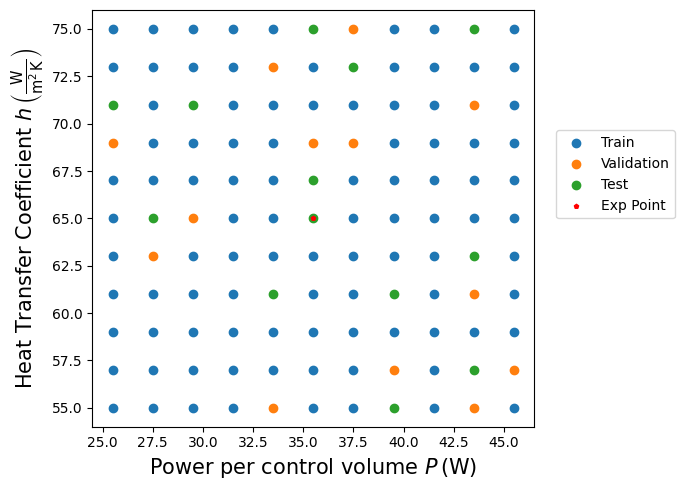

In [6]:
import os

path_res = 'Test_Results/ParametricVerification/'
os.makedirs(path_res, exist_ok=True)

fig, axs = plt.subplots(1, 1, figsize=(7, 5))

axs.scatter(dataset['params']['train'][:, 0, 0], dataset['params']['train'][:, 0, 1], label='Train')
axs.scatter(dataset['params']['valid'][:, 0, 0], dataset['params']['valid'][:, 0, 1], label='Validation')
axs.scatter(dataset['params']['test'][:,  0, 0], dataset['params']['test'][:,  0, 1], label='Test')

axs.scatter(param_mu[target_idx, 0], param_mu[target_idx, 1], s=10, marker='p', color='red', label='Exp Point')

axs.set_xlabel(r'Power per control volume $P\,$(W)', fontsize=15)
axs.set_ylabel(r'Heat Transfer Coefficient $h\,\left(\frac{\text{W}}{\text{m}^2\, \text{K}}\right)$', fontsize=15)
axs.legend(ncols=1, loc=(1.05,0.5))   
plt.tight_layout()

fig.savefig(path_res + 'parametric_verification.pdf', dpi=300)

Defining the spatial domain and the index of the fluid thermocouples

In [7]:
domain = np.arange(0, Nh, 1)

# Define experimental index
exp_idx = np.array([1, 25, 55, 92]) - 1

## Singular Value Decomposition
The data are reduced using the Singular Value Decomposition (SVD)

In [8]:
from scalers import MyScaler
from sklearn.utils.extmath import randomized_svd

rescaling_snaps = list()
Nmodes = []

u_total = dict()
s_total = dict()

modes_number = [10]

for field_i, field in enumerate(var_names):
    u = dataset[field]['train'].reshape(-1, Nh).T
    
    rescaling_snaps.append(MyScaler())
    rescaling_snaps[field_i].fit(u.T)
    
    X = rescaling_snaps[field_i].transform(u.T).T

    assert X.shape[0] == Nh
    assert X.shape[1] == Nt * ntrain
    
    _Nmodes = modes_number[field_i]
    
    Nmodes.append(_Nmodes)
    
    u_svd, s_svd, v_svd = randomized_svd(X, n_components = _Nmodes, n_iter = 'auto')

    if field_i == 0:
        v_total = v_svd
    else:
        v_total = np.vstack((v_total, v_svd))
        
    s_total[field] = s_svd.flatten()
    u_total[field] = u_svd
        
Nmodes = np.asarray(Nmodes)

/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/sriva/miniconda3/envs/ml/lib/python3.10/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: invalid value encountered in matmul
  Q, _ = no

Let us plot the sing vals

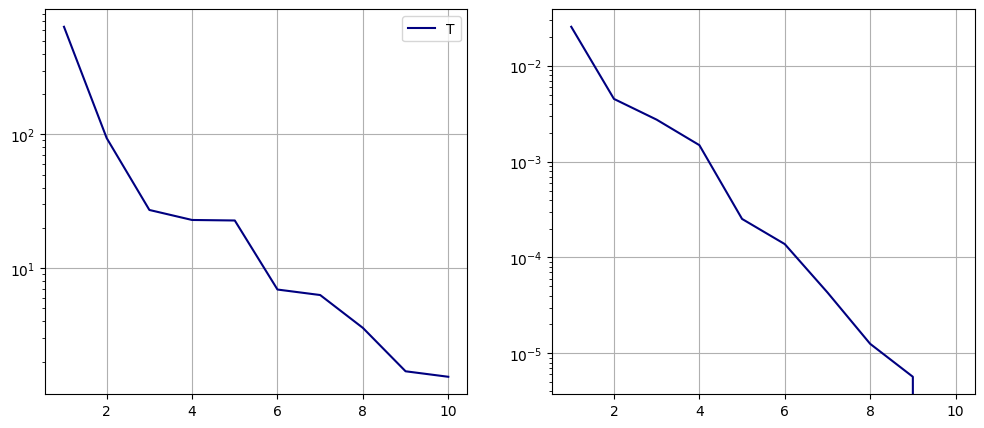

In [9]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, sharex=True, figsize=(12,5))

colors = cm.jet(np.linspace(0,1,len(var_names)))
for field_i, field in enumerate(var_names):
    N_plot = np.arange(1, Nmodes[field_i]+1, 1)
    axs[0].semilogy(N_plot, s_total[field], color=colors[field_i], label=field)
    axs[1].semilogy(N_plot, 1-np.cumsum(s_total[field]**2) / np.sum(s_total[field]**2), color=colors[field_i], label=field)
axs[0].grid()
axs[1].grid()
axs[0].legend()

Check the training error

In [10]:
print(v_total.shape)

for field_i in range(len(var_names)):
    field = var_names[field_i]

    for key in dataset[field].keys():
        true_field = rescaling_snaps[field_i].transform(dataset[field][key].reshape(-1, Nh)).T

        _coeff_POD = np.linalg.multi_dot([
            np.linalg.inv(np.diag(s_total[field])), u_total[field].T, true_field
        ]).T
        rec = np.linalg.multi_dot([u_total[field], np.diag(s_total[field]), _coeff_POD.T])
        errors = np.linalg.norm(rescaling_snaps[field_i].inverse_transform(rec.T) - rescaling_snaps[field_i].inverse_transform(true_field.T), axis = 1) / np.linalg.norm(rescaling_snaps[field_i].inverse_transform(true_field.T), axis=1)

        print(field + ' - '+key)
        print('   max = {:.3e}'.format(np.max(errors)) +' and ave {:.3e}'.format(np.mean(errors)))

(10, 19095)
T - train
   max = 1.939e-02 and ave 3.157e-03
T - valid
   max = 1.914e-02 and ave 3.253e-03
T - test
   max = 1.945e-02 and ave 3.224e-03


Let us store the POD coefficients

In [11]:
_v_POD = dict()

for field in var_names:
    _v_POD[field] = { key: np.linalg.multi_dot([np.linalg.inv(np.diag(s_total[field])),  u_total[field].T, rescaling_snaps[field_i].transform(dataset[field][key].reshape(-1, Nh)).T])
                        for key in  dataset[field].keys()
                    }

Let us reshape the coefficients

In [12]:
n_separation = {
    'train': ntrain,
    'test':  ntest,
    'valid': nvalid
}

v_POD = dict()
for key in list(n_separation.keys()):
    v_POD[key] = np.concatenate([_v_POD[var_names[field_i]][key].T.reshape(n_separation[key], Nt, Nmodes[field_i]) 
                                for field_i in range(len(var_names))], axis=-1)

print(v_POD['train'].shape)
print(v_POD['valid'].shape)
print(v_POD['test'].shape)

(95, 201, 10)
(13, 201, 10)
(13, 201, 10)


## Compute Measures
The positions of the sensors are randomly selected

In [13]:
measured_field = 0

from tqdm import tqdm
num_sensors = 3
sensor_locations = np.arange(0, num_sensors, 1, dtype=int) # [0,1,2]

n_configurations = 3
idx_sensor_locations = np.zeros((num_sensors, n_configurations), dtype=int)
sensors = list()

snap_measurements = list()

np.random.seed(50) # Fixed seed for reproducibility
for kk in tqdm(range(n_configurations), 'Creating sensors'):

    idx_sensor_locations[:, kk] = np.asarray(np.random.choice(domain, size=num_sensors, replace=False), dtype=int)
    
    snap_measurements.append({
        key: dataset[var_names[measured_field]][key][:, :, idx_sensor_locations[:,kk]]
        for key in list(dataset[var_names[measured_field]].keys())
    })

Creating sensors: 100%|██████████| 3/3 [00:00<00:00, 2568.47it/s]


Let us plot the different configurations of sensors

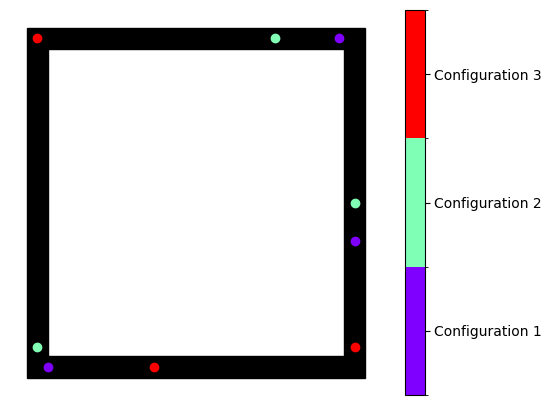

In [15]:
from plots import add_tubes, extract_dynasty_coordinates
import matplotlib.colors as mcolors

fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(6,5))

x_dyn, y_dyn = extract_dynasty_coordinates()

add_tubes(axs, _s = 0.1, facecolors=['black', 'white'])

cmap = cm.rainbow
colors = cmap(np.linspace(0,1,n_configurations))
for kk in range(n_configurations):
    axs.scatter(x_dyn[idx_sensor_locations[:, kk]], y_dyn[idx_sensor_locations[:, kk]], color=colors[kk])

# Create a discrete colormap and normalization
bounds = np.linspace(1, n_configurations+1, n_configurations+1)
norm = mcolors.BoundaryNorm(bounds, cmap.N)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Add the discrete colorbar to the plot
midpoints = (bounds[:-1] + bounds[1:]) / 2
cbar = plt.colorbar(sm, ax=axs, ticks=np.arange(n_configurations + 1))
cbar.ax.set_yticks(np.hstack([midpoints[0::1]]))
cbar.ax.set_yticklabels([f'Configuration {i}' for i in np.hstack([np.arange(1, n_configurations, 1, dtype=int), np.array(3)])])

axs.axis('off')

fig.savefig(path_res+'sensors.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us add noise to the measures

In [16]:
noise_value = 5/100
Xsensor = list()

for kk in range(n_configurations):
    Xsensor.append({
        key: snap_measurements[kk][key] * (1+np.random.normal(scale=noise_value, size=snap_measurements[kk][key].shape))
        for key in list(snap_measurements[kk].keys())
    })

print('Sensors Shape')
print(Xsensor[0]['train'].shape)
print(Xsensor[0]['test'].shape)
print(Xsensor[0]['valid'].shape)

Sensors Shape
(95, 201, 3)
(13, 201, 3)
(13, 201, 3)


Let us plot some configurations

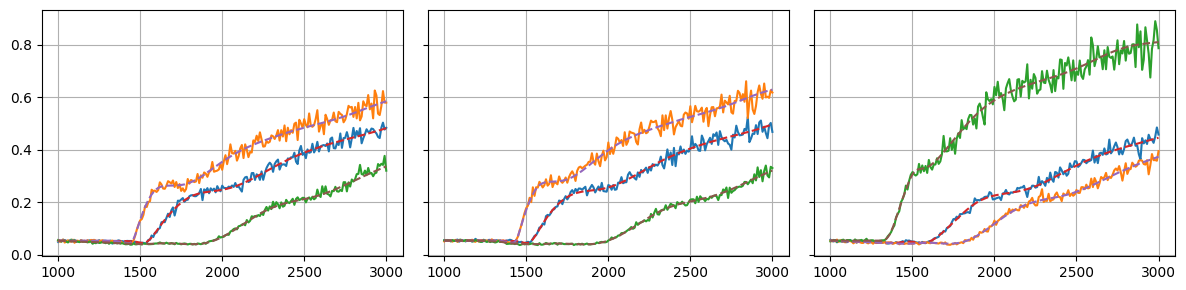

In [17]:
ncols = 3
nrows = 1
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, sharey=True, figsize= (4 * ncols, 3 * nrows))
axs = axs.flatten()

idx_mu = 45
for kk in range(nrows * ncols):
    axs[kk].plot(simulation_time, Xsensor[kk]['train'][idx_mu], label='Spline')
    axs[kk].plot(simulation_time, snap_measurements[kk]['train'][idx_mu], '--', label='FOM')
    axs[kk].grid()
    
plt.tight_layout()

Let us scale them to be in the range $[0, 1]$

In [18]:
from sklearn.preprocessing import MinMaxScaler

rescaled_Xsensor = list()
sens_scaler = list()
for kk in range(n_configurations):
    sens_scaler.append(MinMaxScaler())
    sens_scaler[kk].fit(Xsensor[kk]['train'].reshape(-1, num_sensors))

    rescaled_Xsensor.append({
        key: sens_scaler[kk].transform(Xsensor[kk][key].reshape(-1, num_sensors)).reshape(Xsensor[kk][key].shape)
        for key in list(Xsensor[kk].keys())
    })

print('Rescaled Sensors Shape')
print(rescaled_Xsensor[0]['train'].shape)
print(rescaled_Xsensor[0]['test'].shape)
print(rescaled_Xsensor[0]['valid'].shape)

Rescaled Sensors Shape
(95, 201, 3)
(13, 201, 3)
(13, 201, 3)


## Padding
In this section, the data are prepared to be fed into the SHRED architecture.

At first, let us load the POD coefficients and let us rescale them between 0 and 1.

In [19]:
assert sum(Nmodes) == v_POD['train'].shape[2]

vpod_scaler = MinMaxScaler()
vpod_scaler.fit(v_POD['train'].reshape(-1, sum(Nmodes)))

rescaled_v_POD = {
    key: vpod_scaler.transform(v_POD[key].reshape(-1, sum(Nmodes))).reshape(v_POD[key].shape)
    for key in list(v_POD.keys())
}

Let us create the parameters data

In [20]:
param_scaler = MinMaxScaler()
param_scaler.fit(dataset['params']['train'].reshape(-1, N_params))

rescaled_parameters = {
    key: param_scaler.transform(dataset['params'][key].reshape(-1, N_params)).reshape(dataset['params'][key].shape)
    for key in list(dataset['params'].keys())
}

print('Params Shape')
print(rescaled_parameters['train'].shape)
print(rescaled_parameters['test'].shape)
print(rescaled_parameters['valid'].shape)

print('POD Coeff Shape')
print(rescaled_v_POD['train'].shape)
print(rescaled_v_POD['test'].shape)
print(rescaled_v_POD['valid'].shape)

Params Shape
(95, 201, 2)
(13, 201, 2)
(13, 201, 2)
POD Coeff Shape
(95, 201, 10)
(13, 201, 10)
(13, 201, 10)


Then, let us prepare them for the SHRED architecture

In [21]:
import sys
sys.path.append('../../')

from shred.processdata import Padding, TimeSeriesDataset
import torch

## GPU
device = 'cuda' if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else 'cpu')

lags = 30

# Input Data
train_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['train']), lags).to(device) for kk in range(n_configurations)]
valid_data_in = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['valid']), lags).to(device) for kk in range(n_configurations)]
test_data_in  = [Padding(torch.from_numpy(rescaled_Xsensor[kk]['test']), lags).to(device)  for kk in range(n_configurations)]

train_data_out = Padding(torch.from_numpy(rescaled_v_POD['train']), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.from_numpy(rescaled_v_POD['valid']), 1).squeeze(1).to(device)
test_data_out  = Padding(torch.from_numpy(rescaled_v_POD['test']), 1).squeeze(1).to(device)

# Create Dataset for SHRED training
train_dataset = [TimeSeriesDataset(train_data_in[kk], train_data_out) for kk in range(n_configurations)]
valid_dataset = [TimeSeriesDataset(valid_data_in[kk], valid_data_out) for kk in range(n_configurations)]
test_dataset  = [TimeSeriesDataset(test_data_in[kk],  test_data_out)  for kk in range(n_configurations)]

## SHRED
Let us train the SHRED models for each configuration

In [22]:
from shred.models import SHRED, fit

train_net = True

shred = list()
for kk in range(n_configurations):
    
    shred.append(SHRED( num_sensors, sum(Nmodes), 
                        hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device))

    if train_net:
        print('Training SHRED - configuration '+str(kk+1)+'/'+str(n_configurations))

        fitting_errors = fit(   shred[kk], train_dataset[kk], valid_dataset[kk], 
                                batch_size = 64, epochs = 1000, lr = 1e-3, verbose = True, patience = 30)

        shred[kk].freeze()
        torch.save(shred[kk].state_dict(), path_res+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'.shred')
        print(' ')
    else:
        shred[kk].load_state_dict(torch.load(path_res+'trained_config'+str(kk)+'_measuring_'+str(num_sensors)+'sens_'+var_names[measured_field]+'.shred',
                                             map_location=device))
        shred[kk].freeze()
    

Training SHRED - configuration 1/3
Training done: Training loss = 2.45% 	 Validation loss = 3.12%      
 
Training SHRED - configuration 2/3
Training done: Training loss = 2.47% 	 Validation loss = 3.04%      
 
Training SHRED - configuration 3/3
Training done: Training loss = 2.45% 	 Validation loss = 2.67%      
 


### Testing SHRED
In this section, the reliability of the SHRED network are assessed.

We generate reconstructions from the test set and print mean square error compared to the ground truth.

**Uncertainty Quantification**: the mean and the standard deviation of the output of each configuration of SHRED models is computed.

In [23]:
from shred.processdata import num2p, mre

Ytest_POD_hat = torch.stack([shred[kk](test_data_in[kk]) for kk in range(n_configurations)], dim=0)

Ytest_POD_pred = {
    'mean': Ytest_POD_hat.mean(axis=0),
    'std':  Ytest_POD_hat.std(axis=0) / np.sqrt(n_configurations),
    'cov': torch.stack([torch.cov(Ytest_POD_hat[:, i, :sum(Nmodes)].T) for i in range(Ytest_POD_hat.shape[1])]) / n_configurations
}

# The test data are independent on the configurations of the sensors
print("Mean relative SHRED prediction error on POD coeffs: %s." % num2p(mre(test_data_out,
                                                                            Ytest_POD_pred['mean'])))
print("Std  relative SHRED prediction error on POD coeffs: %s." % num2p((Ytest_POD_pred['std'].pow(2).sum(axis = -1).sqrt() / (test_data_out[:, :sum(Nmodes)]).pow(2).sum(axis = -1).sqrt()).mean()))

Mean relative SHRED prediction error on POD coeffs: 2.24%.
Std  relative SHRED prediction error on POD coeffs: 1.44%.


Let us plot the coveriance over time and parameters

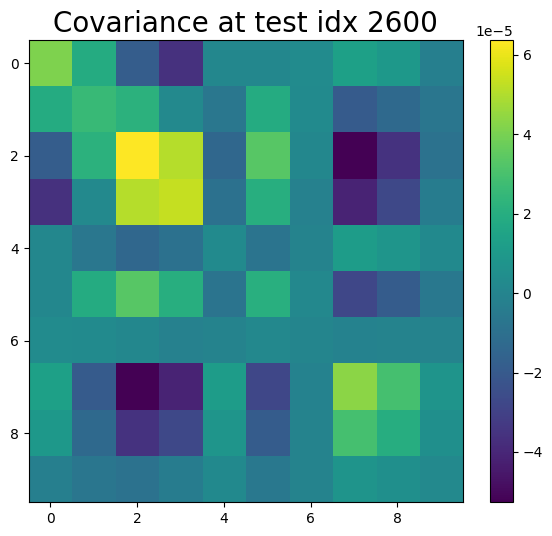

In [25]:
from IPython.display import clear_output as clc

sampling = 100
for mm in range(sampling-1, Ytest_POD_pred['cov'].shape[0], sampling):

    fig, axs = plt.subplots(1,1,figsize=(7,6))

    c = axs.imshow(Ytest_POD_pred['cov'][mm].cpu().numpy(), cmap='viridis', aspect='auto')
    fig.colorbar(c, ax=axs)
    
    axs.set_title('Covariance at test idx %d' % (mm+1), fontsize=20)

    plt.show()
    clc(wait=True)
    plt.close(fig)

Let us reshape the output of the SHRED models and the associated test data to simplify the access to the variables.

In fact, the output of the SHRED models is a 2D array with dimensions $N_p^{test}\cdot N_t \times (R+N_{params})$, given $N_p$ the number of elements in the parameter test set, $N_t$ the number of time steps, $R$ the number of total rank of the latent space and $N_{params}$ the number of parameters (only 1, since $\tau$ only has been considered).

In [26]:
idx_params = {
    'train': idx_train,
    'valid': idx_valid,
    'test':  idx_test
}

reshaped_test_out = test_data_out.cpu().detach().numpy().reshape(len(idx_params['test']), Nt, sum(Nmodes))

reshaped_POD_test_out = {
    'mean': Ytest_POD_pred['mean'].cpu().detach().numpy().reshape(len(idx_params['test']), Nt, sum(Nmodes)),
    'std':  Ytest_POD_pred['std'].cpu().detach().numpy().reshape(len(idx_params['test']), Nt, sum(Nmodes)),
    'cov': Ytest_POD_pred['cov'][:, :sum(Nmodes), :sum(Nmodes)].cpu().detach().numpy().reshape(len(idx_params['test']), Nt, sum(Nmodes), sum(Nmodes)),
    'full': Ytest_POD_hat[:, :, :sum(Nmodes)].cpu().detach().numpy().reshape(n_configurations, len(idx_params['test']), Nt, sum(Nmodes))
}

Let us plot the error for each output of the SHRED

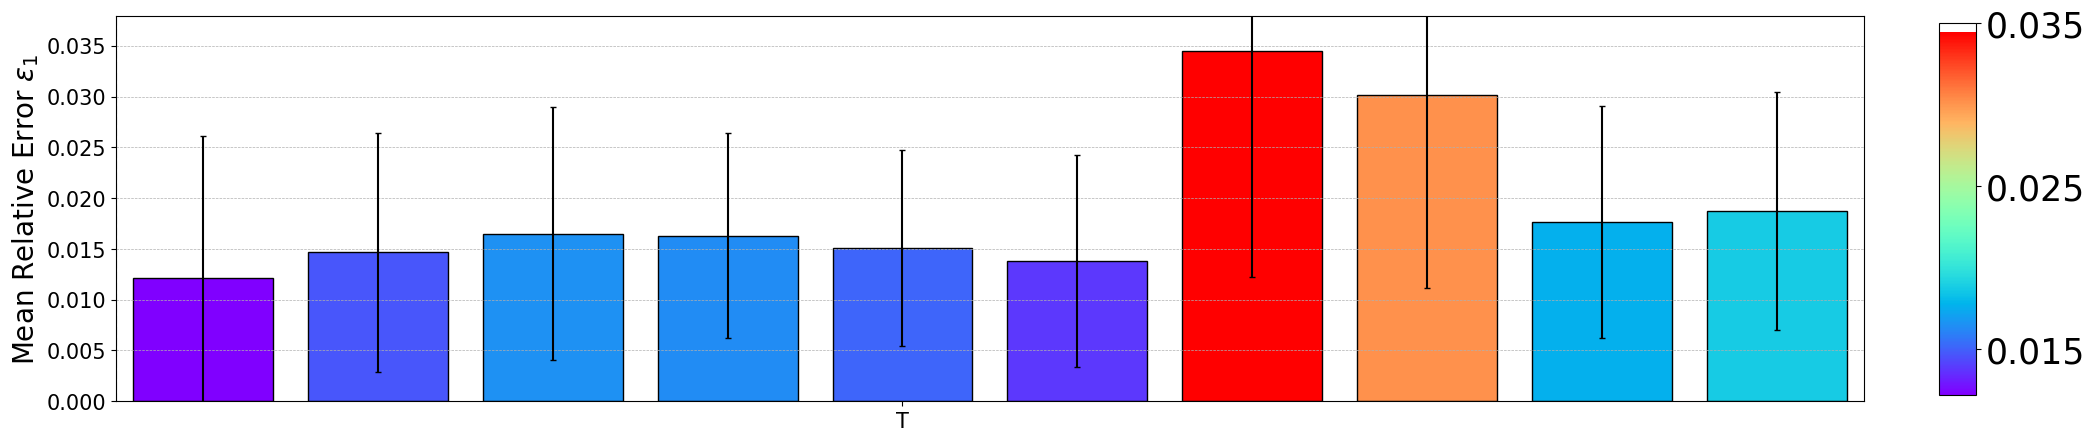

In [31]:
from matplotlib.colors import Normalize

# errors_pod_coeffs already computed
errors_pod_coeffs = [np.mean(np.abs(reshaped_test_out[:, :, pp] - reshaped_POD_test_out['mean'][:, :, pp]), axis=(0,1)) / np.mean(np.abs(reshaped_test_out[:, :, pp]))
                     for pp in range(reshaped_test_out.shape[2])]
err_std_pod_coeffs = [np.mean(reshaped_POD_test_out['std'][:, :, pp], axis=(0,1)) / np.mean(np.abs(reshaped_test_out[:, :, pp]))
                     for pp in range(reshaped_test_out.shape[2])]

fig, axs = plt.subplots(1, 1, figsize=(24, 5))

# Normalize error values to [0,1] for colormap mapping
norm = Normalize(vmin=min(errors_pod_coeffs), vmax=max(errors_pod_coeffs))
cmap = cm.rainbow  # choose your favorite colormap here
colors = cmap(norm(errors_pod_coeffs))

# Plot bars with colors
bars = axs.bar(np.arange(sum(Nmodes)), errors_pod_coeffs, 
               yerr = err_std_pod_coeffs, ecolor='k', capsize=2,
               edgecolor='k',
               color=colors)

# Vertical lines for Nmodes grouping
for pp in range(len(Nmodes)):
    axs.axvline(x=np.cumsum(Nmodes)[pp]-Nmodes[0]-0.5, color='gray', linestyle='--')

axs.tick_params(axis='both', which='major', labelsize=15)
axs.set_ylabel(r'Mean Relative Error $\varepsilon_1$', fontsize=20)

# Add x-ticks for modes grouping
xticks = []
xtick_labels = []
for pp in range(len(Nmodes)):
    xticks.append(np.cumsum(Nmodes)[pp]-Nmodes[0]/2-1)
    xtick_labels.append(f'{var_names[pp]}')
axs.set_xticks(xticks)
axs.set_xticklabels(xtick_labels, rotation=0, fontsize=15)

axs.grid(which='both', axis='y', linestyle='--', linewidth=0.5)
axs.set_xlim(-0.5, sum(Nmodes)-0.5)
axs.set_ylim(0, max(errors_pod_coeffs)*1.1)

# Add colorbar for reference
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axs, fraction=0.02, pad=0.04, aspect=10)
cbar.ax.tick_params(labelsize=25)
# cbar.ax.set_ylabel('Error value', fontsize=30)
cbar.ax.set_yticks(np.arange(0.015, 0.04, 0.01))

Let us plot the first 5 temporal dynamical the reduced coefficients for each field

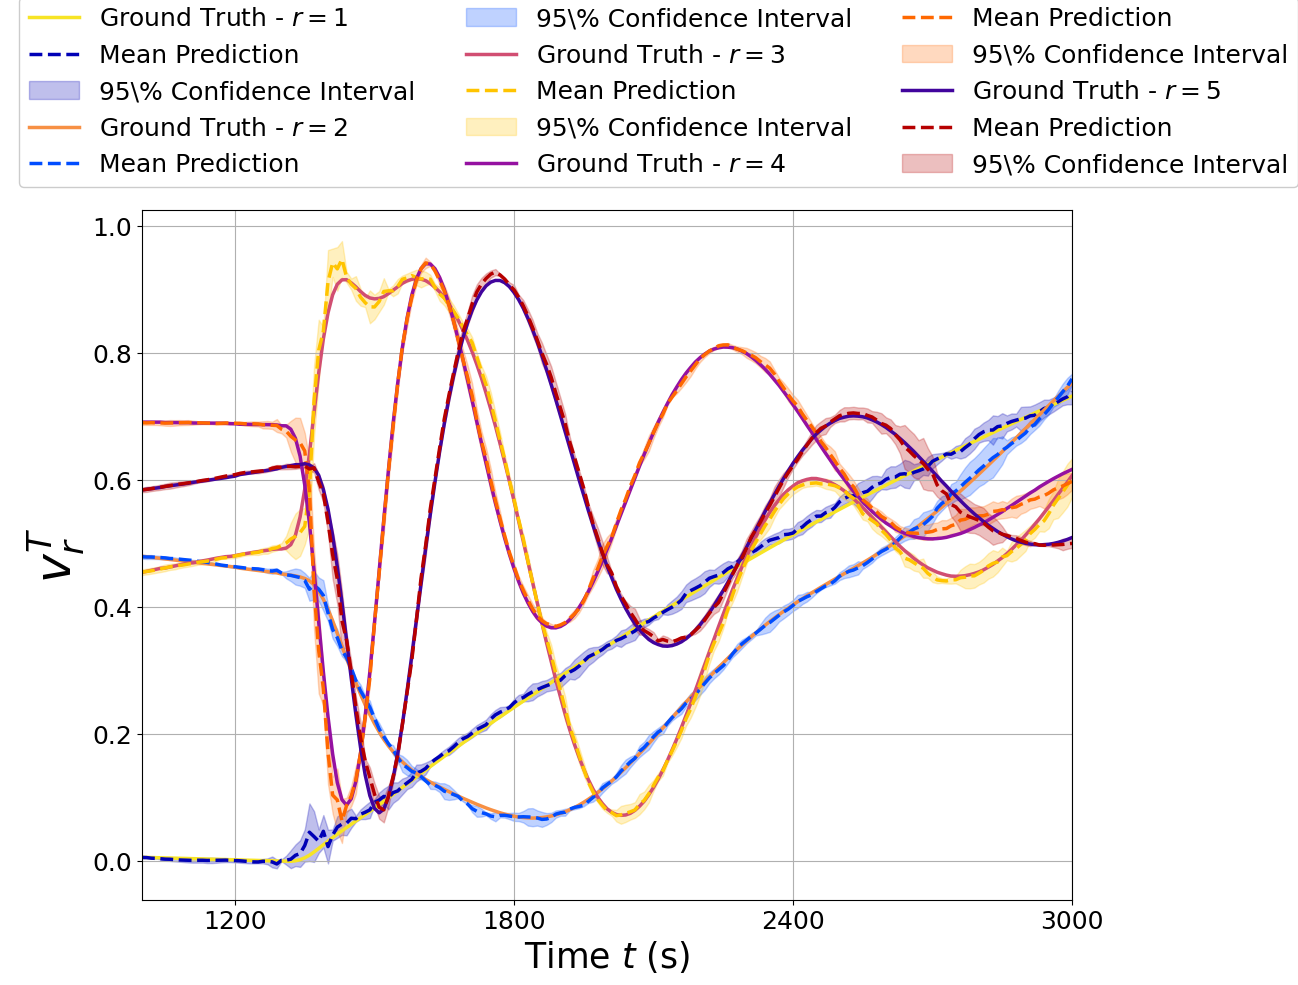

In [32]:
modes_to_plot = 5
param_to_plot = -1

nrows = 1
ncols = 1
fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, figsize=(12 * ncols, 10 * nrows))
axs = np.array([axs]).reshape(-1)

ls = 2.5

for field_i, field in enumerate(var_names):

    idx_to_plot = np.arange(sum(Nmodes[:field_i]),
                            modes_to_plot + sum(Nmodes[:field_i]),
                            1, 
                            dtype=int)

    # colors = cm.jet(np.linspace(0.,1,len(idx_to_plot)))
    colors = cm.jet([0.05, 0.2, 0.7, 0.8, 0.95])
    colors_gt = cm.plasma(np.linspace(0.1,0.95,len(idx_to_plot)))
    for ii, idx in enumerate(idx_to_plot):
        axs[field_i].plot(simulation_time, reshaped_test_out[param_to_plot, :, idx], '-', linewidth=ls, c=colors_gt[-1-ii], label=r'Ground Truth - $r='+str(ii+1)+'$')

        axs[field_i].plot(simulation_time, reshaped_POD_test_out['mean'][param_to_plot, :, idx], '--', c=colors[ii], label=r'Mean Prediction', linewidth=ls)
        axs[field_i].fill_between(  simulation_time, 
                                    y1 = reshaped_POD_test_out['mean'][param_to_plot, :, idx] - 1.96 * reshaped_POD_test_out['std'][param_to_plot, :, idx],
                                    y2 = reshaped_POD_test_out['mean'][param_to_plot, :, idx] + 1.96 * reshaped_POD_test_out['std'][param_to_plot, :, idx],
                                    color=colors[ii], alpha=0.25, label=r'95\% Confidence Interval')

    axs[field_i].set_ylabel(r'$v_r^{'+var_names[field_i]+r'}$', fontsize=35)
    axs[field_i].grid()

    axs[field_i].set_xticks(np.arange(0,3601.0001, 600))
    axs[field_i].set_xlim(min(simulation_time), max(simulation_time))
    axs[field_i].tick_params(axis='both', labelsize=18)
    # axs[field_i].legend(loc=(1.025, 0.35), ncols=2)
    
Line, Label = axs[0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=18, ncols=3, framealpha=1, loc=(0.015, 0.81))

axs = axs.reshape(nrows, ncols)
[ax.set_xlabel(r'Time $t$ (s)', fontsize=25) for ax in axs[-1]]

fig.subplots_adjust(hspace=0.1, top = 0.8, wspace=0.175)
fig.savefig(path_res+'SHRED_dynamics_uq.pdf', format='pdf', dpi=250, bbox_inches='tight')

Let us compare the POD coefficients for the different values of $\boldsymbol{\mu}$ for selected fields

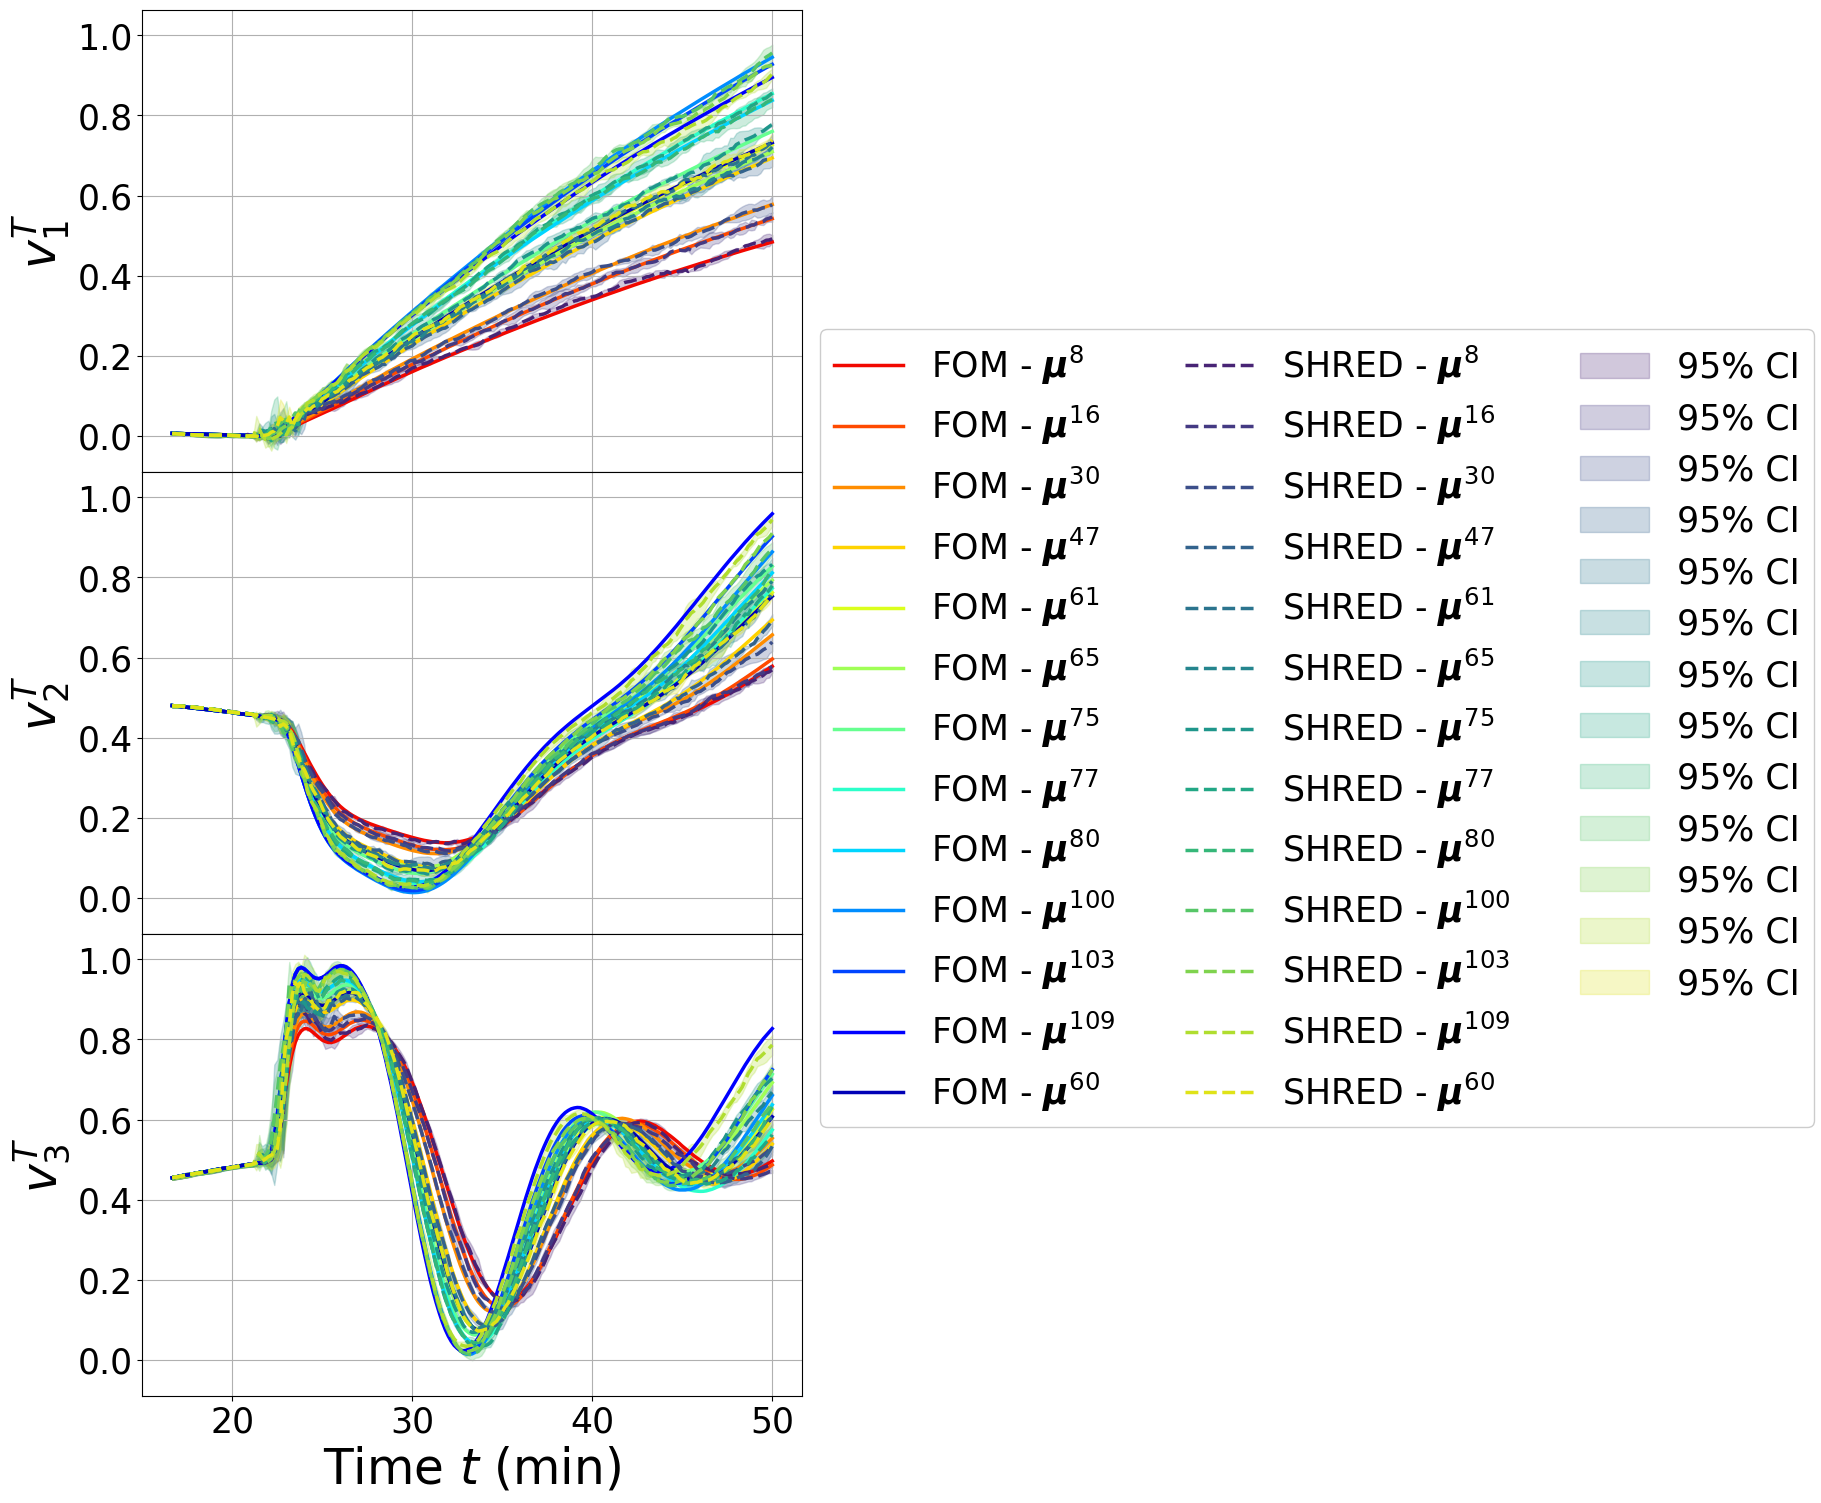

In [33]:
fields_idx_to_plot = [0]
modes_to_plot = 3

nrows = modes_to_plot
ncols = len(fields_idx_to_plot)

fig, axs = plt.subplots(nrows = nrows, ncols=ncols, sharex=True, sharey=True, figsize=(15 * ncols, 6 * nrows))
axs = np.array([axs]).reshape(nrows, ncols)
ls = 2.5

for ii, field_i in enumerate(fields_idx_to_plot):
    idx_to_plot = np.arange(sum(Nmodes[:field_i]),
                            modes_to_plot + sum(Nmodes[:field_i]),
                            1, 
                            dtype=int)

    colors = cm.viridis(np.linspace(0.1,0.95,len(idx_params['test'])))
    colors_gt = cm.jet_r(np.linspace(0.1,0.95,len(idx_params['test'])))

    for jj, idx in enumerate(idx_to_plot):
        for param_to_plot in range(len(idx_params['test'])):
            axs[jj, ii].plot(simulation_time / 60, reshaped_test_out[param_to_plot,:,idx],
                            '-', linewidth=ls, c=colors_gt[param_to_plot], label=r'FOM - $\boldsymbol{\mu}^{'+str(idx_params['test'][param_to_plot])+'}$')
        
        for param_to_plot in range(len(idx_params['test'])):
            axs[jj, ii].plot(simulation_time / 60, reshaped_POD_test_out['mean'][param_to_plot,:,idx],
                                '--', c=colors[param_to_plot], label=r'SHRED - $\boldsymbol{\mu}^{'+str(idx_params['test'][param_to_plot])+'}$', linewidth=ls)
        
        for param_to_plot in range(len(idx_params['test'])):
            axs[jj, ii].fill_between(simulation_time / 60,
                                    y1 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] - 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    y2 = reshaped_POD_test_out['mean'][param_to_plot,:,idx] + 1.96 * reshaped_POD_test_out['std'][param_to_plot,:,idx],
                                    color=colors[param_to_plot], alpha=0.25, label=r'95% CI')
        axs[jj, ii].grid()
        axs[jj, ii].tick_params(axis='both', labelsize=25)
    
# [axs[0, ii].set_title(r'Rank $r='+str(jj+1)+'$', fontsize=35) for ii in range(ncols)]
[axs[jj, 0].set_ylabel(r'$v_'+str(jj+1)+'^{'+var_names[fields_idx_to_plot[ii]]+r'}$', fontsize=35) for jj in range(nrows)]
[axs[-1, ii].set_xlabel(r'Time $t$ (min)', fontsize=35) for ii in range(ncols)]

Line, Label = axs[0,0].get_legend_handles_labels()
fig.legend(Line, Label, fontsize=25, ncols=3, framealpha=1, loc=(0.45, 0.25))

fig.subplots_adjust(left=0, hspace=0.0, right = 0.44, wspace=0.)
fig.savefig(path_res+'SHRED_dynamics_test_parameters.pdf', format='pdf', dpi=250, bbox_inches='tight')

### Decoding to High-Dimensional Space
Let us decode the output of the SHRED models to the high-dimensional space.

The error is computed using the Euclidian norm

In [35]:
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

ave_rel_errors = {
    'mean': np.zeros((len(var_names), len(idx_params['test']), Nt)),
    'std' : np.zeros((len(var_names), len(idx_params['test']), Nt))
}

for field_i in range(len(var_names)):
    field = var_names[field_i]
    idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)

    for param_to_recon in tqdm(range(len(idx_params['test'])), 'Computing error for '+field):
        fom = dataset[field]['test'][param_to_recon].T

        _tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape)
        _tmp_full_v = np.array([vpod_scaler.inverse_transform(reshaped_POD_test_out['full'][kk].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape[0], reshaped_POD_test_out['mean'].shape[1], sum(Nmodes)) for kk in range(n_configurations)])

        recon     = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_mean_v[param_to_recon, :, idx_to_rec]).T).T
        std_recon = np.zeros_like(recon)
        for kk in range(n_configurations):
            sample_recon = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_full_v[kk, param_to_recon, :, idx_to_rec]).T).T
            std_recon += (sample_recon - recon)**2 / (n_configurations - 1)
        std_recon = np.sqrt(std_recon) / np.sqrt(n_configurations)

        ave_rel_errors['mean'][field_i, param_to_recon] = np.linalg.norm(fom - recon, axis=0) / np.linalg.norm(fom, axis=0)
        ave_rel_errors['std'][field_i, param_to_recon]  = np.linalg.norm(std_recon, axis=0)   / np.linalg.norm(fom, axis=0)

Computing error for T: 100%|██████████| 13/13 [00:00<00:00, 1115.57it/s]


Let us plot the errors using bar plots

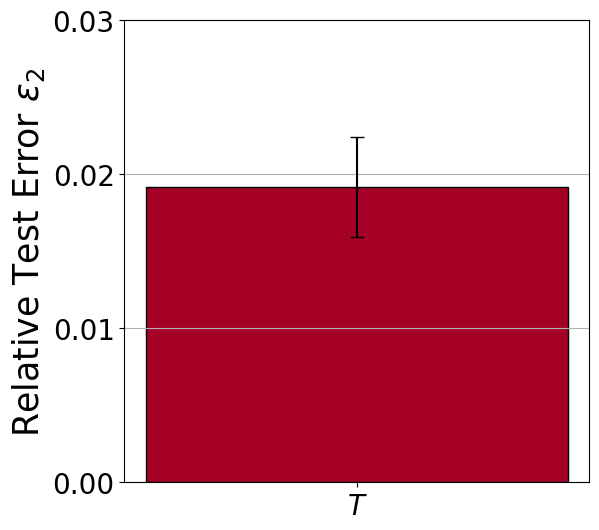

In [43]:
fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(6,6))

colors = cm.jet(np.linspace(0,1, len(var_names)))
axs.bar(np.arange(1, len(var_names)+1, 1), ave_rel_errors['mean'].mean(axis=2).mean(axis=1), 
        yerr = ave_rel_errors['mean'].mean(axis=2).std(axis=1), capsize=5,
        color = cm.RdYlBu(np.linspace(0,1,len(var_names))),
        edgecolor='k')

# axs.set_yscale('log')
axs.set_xticks(np.arange(1,len(var_names)+1,1), ['$'+tex_+'$' for tex_ in var_names])
axs.set_yticks(np.arange(0,0.1,0.01))
axs.set_ylim(0, 0.03)

axs.tick_params(axis='both', labelsize=20)
axs.set_ylabel(r'Relative Test Error $\varepsilon_{2}$', fontsize=25)
axs.grid(axis='y', linestyle='-')
axs.grid(axis='y', which='minor', linestyle='--')

fig.savefig(path_res+'fom_relativerrror_bars.pdf', format='pdf', dpi=250, bbox_inches='tight')

### Contour Plots
In the end, some contour plots are shown to visualize the reconstruction in the high-dimensional space.

At first, let us load the experimental data

In [44]:
exp_data = np.load('../../NuSHRED_Datasets/D3/exp_data.npz')
exp_data = {
    'Time': exp_data['Time'][::5],
    'TC': exp_data['TC'][:, ::5],
}

Then, let us create the images

In [45]:
from turtle import st
from plots import plot_loop_FOM_vs_SHRED

path_fig = path_res+'Figs/'
os.makedirs(path_fig, exist_ok=True)

param_to_plot = -1
field = var_names[0]

fom = dataset[field]['test'][param_to_plot].T

# Reconstruct the FOM
idx_to_rec = np.arange(sum(Nmodes[:field_i]),  sum(Nmodes[:field_i+1]),  1, dtype=int)
_tmp_mean_v = vpod_scaler.inverse_transform(reshaped_POD_test_out['mean'].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape)
_tmp_full_v = np.array([vpod_scaler.inverse_transform(reshaped_POD_test_out['full'][kk].reshape(-1, sum(Nmodes))).reshape(reshaped_POD_test_out['mean'].shape[0], reshaped_POD_test_out['mean'].shape[1], sum(Nmodes)) for kk in range(n_configurations)])

recon     = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_mean_v[param_to_plot, :, idx_to_rec]).T).T
std_recon = np.zeros_like(recon)
for kk in range(n_configurations):
    sample_recon = rescaling_snaps[field_i].inverse_transform((u_total[field] @ np.diag(s_total[field]) @ _tmp_full_v[kk, param_to_plot, :, idx_to_rec]).T).T
    std_recon += (sample_recon - recon)**2 / (n_configurations - 1)
std_recon = np.sqrt(std_recon) / np.sqrt(n_configurations)

for time_idx in tqdm(range(0, Nt, 5)):
    filename = path_fig+'SHRED_TC_time{:.2f}.png'.format(simulation_time[time_idx])
    _fig = plot_loop_FOM_vs_SHRED(  fom, recon, simulation_time, time_idx, 0, 
                                    exp_idx, std_shred = std_recon, exp_data = exp_data,
                                    lims = [fom.min(), fom.max()],
                                    cmap = cm.turbo, sampling_exp=2)

    axs = _fig.get_axes()
    annotate = r'Parameters: $\boldsymbol{{\mu}}^\star = [P^\star, h^\star] = \left[{:.2f} \, W, {:.2f} \, \frac{{W}}{{m^2 \, K}}\right]$'.format(
        param_mu[idx_params['test'][param_to_plot], 0],
        param_mu[idx_params['test'][param_to_plot], 1]
    )
    axs[3].annotate(annotate, xy=(0.6, -0.1), xycoords='axes fraction', fontsize=18,
                    bbox=dict(facecolor='yellow', edgecolor='black', boxstyle='round,pad=0.5'),
                    ha='center', va='center')

    _fig.savefig(filename, format='png', dpi=100, bbox_inches='tight')
    plt.close(_fig)

100%|██████████| 41/41 [00:12<00:00,  3.32it/s]


Let us create the gif

In [46]:
from plots import make_gif

make_gif(path_fig, path_res+'SHRED_TC.gif', duration=100)